### Basic circular CPG
Just produces a circle continuously.

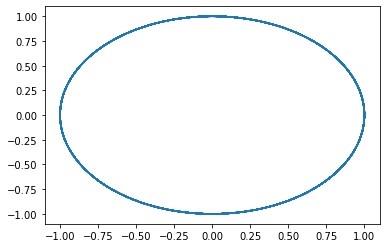

In [1]:
import matplotlib.pyplot as plt

dt = 0.0001
x = 1; y = 0

activate = []
deactivate = []

for ii in range(1000000):
    x = x + -y*dt
    y = y + x*dt
    activate.append(x)
    deactivate.append(y)
plt.plot(activate, deactivate)
plt.show()

### sin CPG
Sinisoidal CPG that displays smooth transitions between configurations.

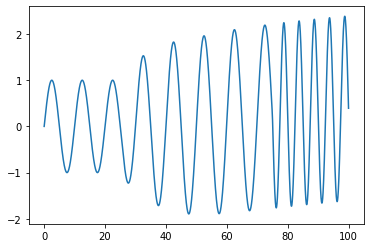

In [2]:

import math
import matplotlib.pyplot as plt
import numpy as np

amp = 1
camp = 0.1
phase = 0
offset = 0
coff = 0.01
frequency = 0.1
dt = 0.0001
time = np.arange(0,100,dt)
iterations = 1000000

def dp(frequency):
    return 2 * 3.141596 * frequency

def da(amp_target):
    return camp * (amp_target - amp)

def do(offset_target):
    return coff * (offset_target - offset)

def output():
    return amp * math.sin(phase) + offset

def update_values(amp_target = 1, offset_target = 0, frequency_target = 0.1):
    global phase, amp, offset
    phase = phase + dp(frequency_target) * dt
    amp = amp + da(amp_target) * dt
    offset = offset + do(offset_target) * dt

outputs = []

# showing off how cpgs can smoothly transition between states when 
# you change their parameters
for i in range(iterations):
    if i < iterations/4:
        update_values()
    elif i < iterations/4 * 2:
        update_values(2, 0)
    elif i < iterations/4 *3:
        update_values(2,1)
    else:
        update_values(2,1,0.2)
    outputs.append(output())

plt.plot(time, outputs)
plt.show()

### CPG signals with phase

The below will show two oscillatory patterns that work in or out of phase with each other. Again, parameter transition is smooth. 

See: https://www.youtube.com/watch?v=hZgxlShnTH4&t=458s

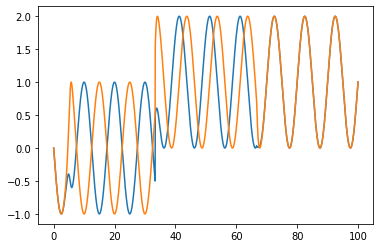

In [3]:
import math
import numpy as np

pi = 3.141569
amp = 1
camp = 0.8
phase = [pi, -pi]
offset = np.array([0,0])
coff = 0.01
frequency = 0.1
dt = 0.0001
result = 0

iterations = 1000000

def dp(frequency, idx, phase, phase_offset_target):
    if idx == 0:
        return 2 * pi * frequency + 1 * amp * math.sin(phase[1]-phase[0]-phase_offset_target)
    else:
        return 2 * pi * frequency + 1 * amp * math.sin(phase[0]-phase[1]+phase_offset_target)

def do(offset_target):
    return coff * (offset_target - offset)

def update_values(amp_target = 1, offset_target = np.array([0,0]), frequency_target = 0.1, phase_offset_target = pi):
    global phase, amp, offset
    for i in range(2):
        phase[i] = phase[i] + dp(frequency_target, i, phase, phase_offset_target) * dt
        
    amp = amp + da(amp_target) * dt
    offset = offset + do(offset_target)
    
def output():
    return amp * np.sin(phase) + offset

outputs = []
n1 = []
n2 = []
for i in range(iterations):
    if i < iterations / 3:
        update_values()
    elif i < 2 * iterations / 3:
        update_values(offset_target = np.array([1,1]), phase_offset_target = pi + 1.57)
    else:
        update_values(offset_target = np.array([1,1]), phase_offset_target = 2*pi)

    result = output()
    n1.append(result[0])
    n2.append(result[1])


plt.plot(time, n1)
plt.plot(time, n2)
plt.show()

### Salamandra Robotica

The below are oscillatory patterns for walking where legs 
rotate in a circle. The signal produced could be used by a
PD-controller in one scenario. 

In this case there are 4 neurons, one for each leg.

The output function came from: Salamandra Robotica II: An Amphibious Robot to Study Salamander-Like Swimming and Walking Gaits. Alessandro Crespi et al.

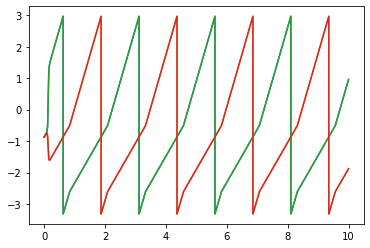

In [4]:
import math
from math import pi, sin, floor
import numpy as np
import matplotlib.pyplot as plt

amp = 1
phase = [0, 0, 0, 0]
f = 0.4
dt = 0.0001
iterations = 100000
time = np.arange(0,iterations * dt, dt)
dr = 0.5
phase_bias = [[0,pi,0,pi],[-pi,0,-pi,0],[0,pi,0,pi],[-pi,0,-pi,0]]
weights = [[0,20,10,20],[20,0,20,10],[10,20,0,20],[20,10,20,0]]
thetlg = -pi / 6
thettg = -5 * pi / 6

def tranop(x):
    if x > pi:
        if (floor(x/pi) % 2 == 1):
            t = (x % (2*pi)) - 2*pi
        else:
            t = (x % (2*pi))

        return t
    return x

# intermediate variables
Sf = (2 * pi - (thetlg - thettg)) / ((1 - dr) * 2 * pi)
Ss = (thetlg - thettg) / (dr * 2 * pi)
thettg_in = tranop(thettg - dr * 2 * pi) + 2*pi # this value needs to be in the interval [-pi, pi], thus add 2pi

def dp(idx):
    phasediff = 2 * pi * f
    for i in range(len(phase)):
        if i != idx:
            phasediff += amp * weights[idx][i] * sin(phase[i] - phase[idx] - phase_bias[idx][i])
    return phasediff
            
def update_values():
    global phase, amp, offset
    for i in range(4):
        phase[i] = phase[i] + dp(i) * dt
            
def output():
    act = []
    for i in range(4):
        if tranop(phase[i]) <= thettg:
            act.append(thettg + (tranop(phase[i]) - thettg) * Sf)
        elif tranop(phase[i]) <= thettg_in:
            act.append(thettg + (tranop(phase[i]) - thettg) * Ss)
        else:
            act.append(thetlg + (tranop(phase[i]) - thettg_in) * Sf)
    
    return act

outputs = []
n1 = []
n2 = []
n3 = []
n4 = []

for i in range(iterations):
    if i < iterations:
        update_values()
        
    result = output()
    n1.append(result[0])
    n2.append(result[1])
    n3.append(result[2])
    n4.append(result[3])

plt.plot(time, n1)
plt.plot(time, n2)
plt.plot(time, n3)
plt.plot(time, n4)
plt.show()

Much as before, but this time a neuron which acts as a dependency for two of the legs. In the salamander robot, this neuron acted as one of the spine components.

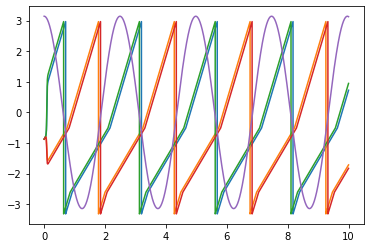

In [5]:
import math
from math import pi, sin, cos, floor
import numpy as np
import matplotlib.pyplot as plt

amp = pi
amp_target = pi
camp = 2
offset = 0
offset_target = 0
coff = 1
phase = [0, 0, 0, 0, 0]
f = 0.4
dt = 0.0001
iterations = 100000
time = np.arange(0,iterations * dt, dt)
dr = 0.5
offset = 0

phase_bias = [[0,pi,0,0,0], [-pi,0,0,0,0], [0,0,0,pi,0], [0,0,-pi,0,0], [0,0,0,0,0]]
weights = [[0,20,10,0,10],[20,0,0,10,10],[10,0,0,20,0],[0,10,20,0,0], [10,10,0,0,0]]

thetlg = -pi / 6
thettg = -5 * pi / 6

def tranop(x):
    if x > pi:
        if (floor(x/pi) % 2 == 1):
            t = (x % (2*pi)) - 2*pi
        else:
            t = (x % (2*pi))

        return t
    return x


# intermediate variables
Sf = (2 * pi - (thetlg - thettg)) / ((1 - dr) * 2 * pi)
Ss = (thetlg - thettg) / (dr * 2 * pi)
thettg_in = tranop(thettg - dr * 2 * pi) + 2*pi

def da():
    return camp * (amp_target - amp)

def do():
    return coff * (offset_target - offset)

def dp(idx):
    phasediff = 2 * pi * f
    for i in range(len(phase)):
        if i != idx:
            phasediff += amp * weights[idx][i] * sin(phase[i] - phase[idx] - phase_bias[idx][i])
    return phasediff
            
def update_values():
    global amp, offset
    for i in range(len(phase)):
        phase[i] = phase[i] + dp(i) * dt
    amp = amp + da() * dt
    offset = offset + do() * dt
    
def output():
    act = []
    for i in range(5):
        if i == 4:
            act.append(amp * cos(phase[i]) + offset)
        elif tranop(phase[i]) <= thettg:
            act.append(thettg + (tranop(phase[i]) - thettg) * Sf)
        elif tranop(phase[i]) <= thettg_in:
            act.append(thettg + (tranop(phase[i]) - thettg) * Ss)
        else:
            act.append(thetlg + (tranop(phase[i]) - thettg_in) * Sf)
    
    return act

outputs = []
n1 = []
n2 = []
n3 = []
n4 = []
n5 = []

for i in range(iterations):
    if i < iterations:
        update_values()
        
    result = output()
    n1.append(result[0])
    n2.append(result[1])
    n3.append(result[2])
    n4.append(result[3])
    n5.append(result[4])
    
plt.plot(time, n1)
plt.plot(time, n2)
plt.plot(time, n3)
plt.plot(time, n4)
plt.plot(time, n5)
plt.show()

### Buehler Clocks

Buehler clocks as defined in: [Justin Seipel and Philip Holmes. A simple model for clock-actuated legged locomotion. Regular and chaotic dynamics, 12(5):502–520, 2007](https://link.springer.com/article/10.1134%2FS1560354707050048)

Using this set of equations

\begin{equation*}
\phi _{r} \ =\ \begin{cases}
-\phi _{0} \ -\ \phi _{s} /2\ +_{\ } \omega _{s} t, & if\ t\leqslant t_{s}\\
-\phi _{0} +\phi _{s} /2\ +\ \omega _{f}( t-t_{s}) , & if\ t\  >\ t_{s} \ and\ t\leqslant t_{c}
\end{cases}
\end{equation*}

where $\displaystyle \omega _{s} \ =\ \phi _{s} /t_{s}$ and $\displaystyle \omega_{f}\ =\ ( 2\pi \ -\ \phi _{s}) /( t_{c} \ -\ t_{s})$. $\phi_r $ is the output signal $\phi_0 $ is the angle offset,  $\phi_s $ is the stance angle,   $t_s $ is the duty time, $t$ is time, and $t_c$ is the cycle period.

The advantage here being that the duty factor is dynamic, unlike previous CPGs. 

Such signals are good in robots like the R-Hex platform.

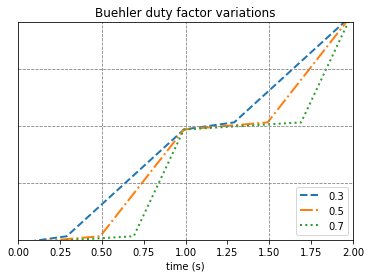

In [6]:
from math import pi, floor, sin
import matplotlib.pyplot as plt
import numpy as np

class BeuhlerClock:
    def __init__(self, stance_angle = np.array([pi / 4, pi / 4, pi / 4, pi / 4, pi / 4, pi / 4]), frequency = 1, duty_factor = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5]), phase_offset = np.array([0,0,0,0,0,0]), dt = 0.01):
        self.stance_angle = stance_angle
        self.duty_factor = duty_factor
        self.phase_offset = phase_offset
        self.dt = dt
        self.time = 0
        self.frequency = frequency
        self.period = 1 / self.frequency
        self.duty_time = self.duty_factor * self.period 
        self.phase_bias = self.period * phase_offset
        self.phase = [0,0,0,0,0,0]
        for i in range(6):
            self.phase[i] += self.phase_bias[i]


    def update(self):
        update = []
        for i in range(6):
            update.append(self.phase[i] + self.dt)

        for i in range(6):
            self.phase[i] = update[i]
            
    # as defined in Justin Seipel and Philip Holmes. A simple model for clock-actuated legged locomotion.Regular and chaotic dynamics, 12(5):502–520, 2007
    def output(self):
        output = [0,0,0,0,0,0]
        for i in range(6):
            t = self.phase[i] % self.period
            if(t <= self.duty_time[i]):
                output[i] =  - self.stance_angle[i] / 2 + (self.stance_angle[i] / self.duty_time[i]) * t
            elif(t > self.duty_time[i] and t <= self.period):
                output[i] = self.stance_angle[i] / 2 + ((2 * pi - self.stance_angle[i])/(self.period - self.duty_time[i])) * (t - self.duty_time[i])

        return output
    
duty_factor = np.array([0.3, 0.5, 0.7, 0.5, 0.5, 0.5])
#bclock = BeuhlerClock(phase_offset = 0.25, duty_factor = duty_factor, frequency = 1)
bclock = BeuhlerClock(phase_offset = np.array([0,0,0,0,0,0]), duty_factor = duty_factor, stance_angle = np.array([pi / 8, pi / 8, pi / 8, pi / 4, pi / 2, pi]), frequency = 1)

#bclock = BeuhlerClock(phase_offset = 0.25, frequency = 1)

n1 = []
n2 = []
n3 = []
n4 = []
n5 = []
n6 = []

comp_count = 1
comp_mult = 0
comp_mult1 = 0
comp_mult2 = 0
comp_mult3 = 0
comp_mult4 = 0
comp_mult5 = 0

t = 0
dt = 0.01
time_length = 2

for i in range(int(time_length / dt)):

    bclock.update()
    output = bclock.output()
    
    n1.append(output[0])
    n2.append(output[1])
    n3.append(output[2])
    n4.append(output[3])
    n5.append(output[4])
    n6.append(output[5])
    
    comp_mult = floor(bclock.phase[0] / bclock.period)
    comp_mult1 = floor(bclock.phase[1] / bclock.period)
    comp_mult2 = floor(bclock.phase[2] / bclock.period)
    comp_mult3 = floor(bclock.phase[3] / bclock.period)
    comp_mult4 = floor(bclock.phase[4] / bclock.period)
    comp_mult5 = floor(bclock.phase[5] / bclock.period)

    n1[i] += comp_mult * 2 * pi
    n2[i] += comp_mult1 * 2 * pi
    n3[i] += comp_mult2 * 2 * pi
    n4[i] += comp_mult3 * 2 * pi
    n5[i] += comp_mult4 * 2 * pi
    n6[i] += comp_mult5 * 2 * pi

    
t = np.arange(0, 2, dt)

# plt.tick_params(
#     axis='y',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off
fig, ax = plt.subplots(1)

ax.set_yticklabels([])


ax.plot(t,n1,linestyle='--', label="0.3", linewidth = 2)
ax.plot(t,n2,linestyle='-.', label="0.5", linewidth = 2)
ax.plot(t,n3,linestyle=':', label="0.7", linewidth = 2)
# ax.plot(t,n4,linestyle='--', label="45", linewidth = 2)
# ax.plot(t,n5,linestyle='-.', label="90", linewidth = 2)
# ax.plot(t,n6,linestyle=':', label="180", linewidth = 2)

ax.axvline(x=1, color='gray', linestyle='--', linewidth = 0.8)
ax.axvline(x=1.5, color='gray', linestyle='--', linewidth = 0.8)
ax.axvline(x=0.5, color='gray', linestyle='--', linewidth = 0.8)

ax.axhline(y=0, color='gray', linestyle='--', linewidth = 0.8)
ax.axhline(y=pi, color='gray', linestyle='--', linewidth = 0.8)
ax.axhline(y=2*pi, color='gray', linestyle='--', linewidth = 0.8)
ax.axhline(y=3*pi, color='gray', linestyle='--', linewidth = 0.8)

plt.xlim(0, 2)
plt.ylim(0, 12)

ax.legend()
plt.xlabel('time (s)')
# plt.ylabel('leg angle (radians)')
plt.title('Buehler duty factor variations')
plt.gca().axes.get_yaxis().set_visible(False)

plt.savefig("buehler_df_variations.png")

plt.show()